In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']='0,1,2'

In [2]:
import pandas as pd
import numpy as np
bins_train = abs(pd.read_csv('/srv/scratch/jjwang01/proseq/bins_train.csv.gz', compression='gzip', index_col=0))
bins_val = abs(pd.read_csv('/srv/scratch/jjwang01/proseq/bins_val.csv.gz', compression='gzip', index_col=0))
bins_test = abs(pd.read_csv('/srv/scratch/jjwang01/proseq/bins_test.csv.gz', compression='gzip', index_col=0))

/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys


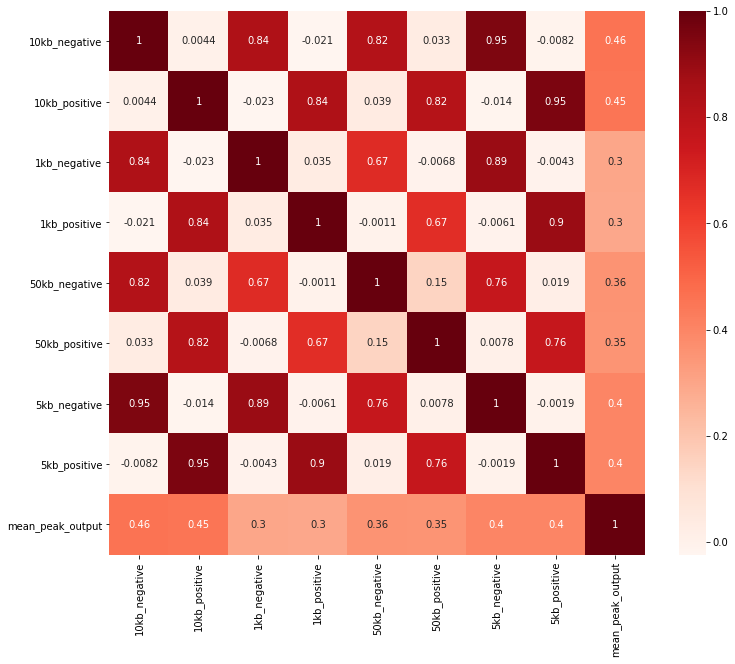

In [3]:
# Pearson correlation as sanity check
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
cor = np.log2(bins_train).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log2
  after removing the cwd from sys.path.


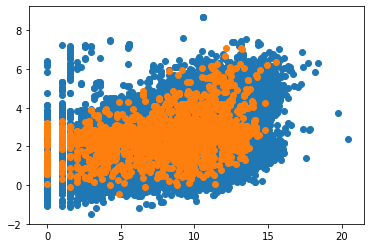

In [4]:
plt.scatter(np.log2(bins_train['10kb_positive'].values), np.log2(bins_train['mean_peak_output'].values))
#plt.show()

plt.scatter(np.log2(bins_val['10kb_negative'].values), np.log2(bins_val['mean_peak_output'].values))
plt.show()

In [5]:
bins_train = np.log2(bins_train)
bins_val = np.log2(bins_val)
bins_test = np.log2(bins_test)

# convert to back to negative values
bins_train['1kb_negative'] = -1 * bins_train['1kb_negative']
bins_train['5kb_negative'] = -1 * bins_train['5kb_negative']
bins_train['10kb_negative'] = -1 * bins_train['10kb_negative']
bins_train['50kb_negative'] = -1 * bins_train['50kb_negative']

bins_val['1kb_negative'] = -1 * bins_val['1kb_negative']
bins_val['5kb_negative'] = -1 * bins_val['5kb_negative']
bins_val['10kb_negative'] = -1 * bins_val['10kb_negative']
bins_val['50kb_negative'] = -1 * bins_val['50kb_negative']

bins_test['1kb_negative'] = -1 * bins_test['1kb_negative']
bins_test['5kb_negative'] = -1 * bins_test['5kb_negative']
bins_test['10kb_negative'] = -1 * bins_test['10kb_negative']
bins_test['50kb_negative'] = -1 * bins_test['50kb_negative']

/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log2
  """Entry point for launching an IPython kernel.
/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/users/jjwang01/.conda/envs/proseq/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


0.23695528599063934
0.06954415882020404


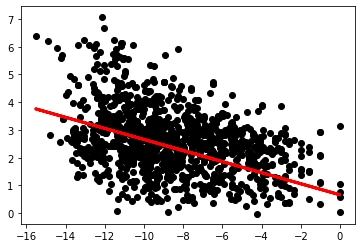

In [6]:
# run sklearn linear regression on the most correlated feature (10kb_negative)
from sklearn.linear_model import LinearRegression

# get rid of all inf and -inf values
bins_train = bins_train[~bins_train.isin([np.nan, np.inf, -np.inf]).any(1)]
bins_val = bins_val[~bins_val.isin([np.nan, np.inf, -np.inf]).any(1)]
bins_test = bins_test[~bins_test.isin([np.nan, np.inf, -np.inf]).any(1)]

reg = LinearRegression().fit(bins_train['10kb_negative'].values.reshape(-1,1), bins_train['mean_peak_output'].values)
print(reg.score(bins_train['10kb_negative'].values.reshape(-1,1), bins_train['mean_peak_output'].values))

y_val = reg.predict(bins_val['10kb_negative'].values.reshape(-1,1))
print(reg.score(bins_val['10kb_negative'].values.reshape(-1,1), bins_val['mean_peak_output'].values))

plt.scatter(bins_val['10kb_negative'].values.reshape(-1,1), bins_val['mean_peak_output'].values, color='black')
plt.plot(bins_val['10kb_negative'].values.reshape(-1,1), y_val, color='red', linewidth=3)
# output score is .2369 for train, .0695 for validation

(0.6232018, 3.441894668756912e-135)


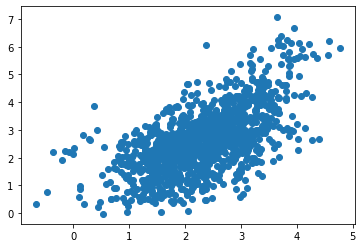

In [7]:
from scipy.stats.stats import pearsonr, spearmanr

y_train = bins_train['mean_peak_output'].to_numpy(dtype=np.float32)
X_train = bins_train.drop(['mean_peak_output'], axis=1).to_numpy(dtype=np.float32)
y_val = bins_val['mean_peak_output'].to_numpy(dtype=np.float32)
X_val = bins_val.drop(['mean_peak_output'], axis=1).to_numpy(dtype=np.float32)
y_test = bins_test['mean_peak_output'].to_numpy(dtype=np.float32)
X_test = bins_test.drop(['mean_peak_output'], axis=1).to_numpy(dtype=np.float32)

reg = LinearRegression().fit(X_train, y_train)

plt.scatter(reg.predict(X_val), y_val)
print(pearsonr(reg.predict(X_val), y_val))

In [8]:
import torch
import torch.nn as nn
import torch.utils.data as data_utils

print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

3
GeForce GTX 1080
True


In [9]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred
    
    
N, D_in, H, D_out = 50, 8, 5, 1

y_train = torch.tensor(y_train, requires_grad=True)
X_train = torch.tensor(X_train, requires_grad=True)
train_tensor = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(dataset=train_tensor, batch_size=N, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available()
                      else "cpu")

model = TwoLayerNet(D_in, H, D_out)

loss_fn = torch.nn.MSELoss(reduction='sum')

In [16]:
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(500):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    print(t, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # spearman and pearson correlations predicted wrt true at the end of validation
    # e-11: 3316252160, hidden: 3
    # e-10: 3316253696, hidden: 5

0 3709118208.0
1 3729956608.0
2 3712619008.0
3 3711941632.0
4 3674953728.0
5 3685519616.0
6 3684678912.0
7 3659853824.0
8 3655525632.0
9 3660799488.0
10 3649770496.0
11 3636910336.0
12 3639377408.0
13 3636903680.0
14 3626630656.0
15 3621427968.0
16 3621628928.0
17 3618421504.0
18 3611651072.0
19 3607856384.0
20 3606783744.0
21 3602710016.0


KeyboardInterrupt: 

In [17]:
torch.save(model.state_dict(), '/srv/scratch/jjwang01/proseq/fullyconnected')

In [19]:
model = TwoLayerNet(D_in, H, D_out)
model.load_state_dict(torch.load('/srv/scratch/jjwang01/proseq/fullyconnected'))
model.eval()

TwoLayerNet(
  (linear1): Linear(in_features=8, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
X_val = torch.tensor(X_val, requires_grad=True)
y_pred = model(X_val).cpu().detach().numpy().flatten()

from scipy.stats.stats import pearsonr, spearmanr
print(pearsonr(y_val, y_pred))
print(spearmanr(y_val, y_pred))

(0.36535725, 1.0552600500511584e-40)
SpearmanrResult(correlation=0.35485688626951706, pvalue=2.437751478018801e-38)


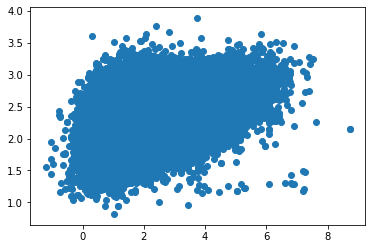

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

y_pred = model(X_train).cpu().detach().numpy().flatten()
# scatter plots for correlation
plt.scatter(x=y_train.detach().numpy(), y=y_pred)
plt.show()

In [22]:
print(y_pred)

[2.4417925 2.4556715 2.3514042 ... 1.8139932 2.2790697 1.4765995]
